In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader,Dataset
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
print(torch.version.cuda)

10.0.130


In [4]:
#Preparing the dataset

data_path = 'data/dataset/'

train_dataset = torchvision.datasets.ImageFolder( root = data_path, transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])) 

len(train_dataset)

26724

In [5]:
train_loader = DataLoader( train_dataset, batch_size = 32, num_workers = 0, shuffle = True)

In [6]:
sample = next(iter(train_dataset))

In [7]:
image , label = sample

label:  0


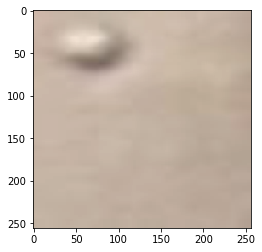

In [8]:
img = image.numpy().transpose((1,2,0))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std*img + mean
img = np.clip(img, 0, 1)

plt.imshow(img)
print('label: ',label)

In [9]:
batch = next(iter(train_loader))

In [10]:
images , labels = batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels :  tensor([36, 24, 18, 22, 36, 30, 11,  6,  2, 26, 18,  7, 36, 11, 23,  3, 36, 34,
         9, 12, 13, 12, 12, 33, 34,  2, 14, 18,  5, 10, 23,  9])


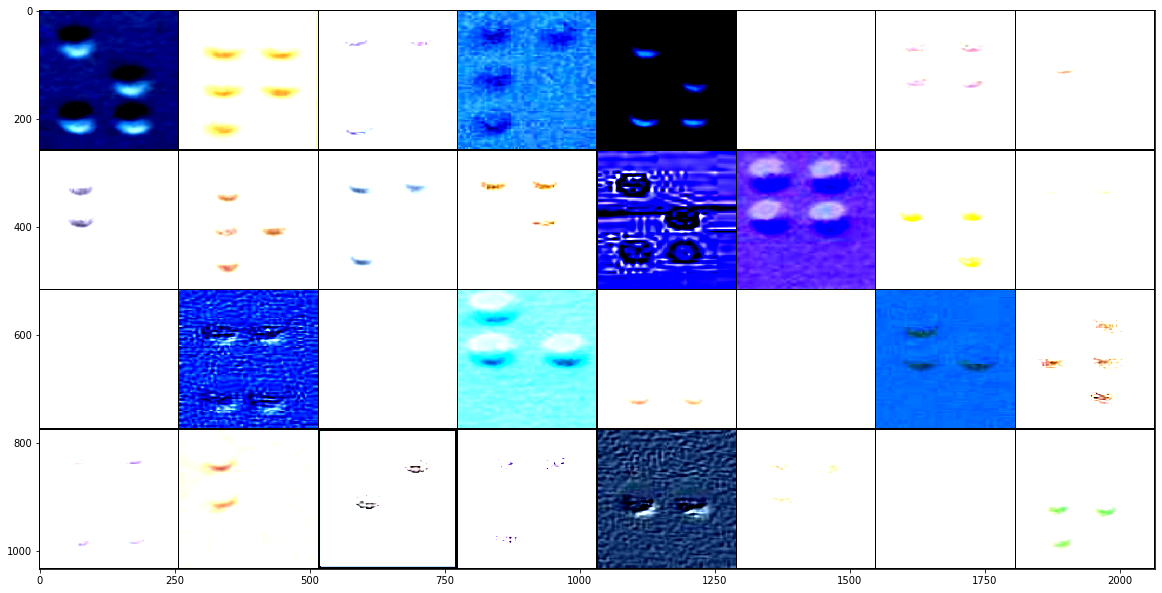

In [11]:
grid = torchvision.utils.make_grid(images,nrow=8)

plt.figure(figsize = (20,20))
plt.imshow(np.transpose(grid,(1,2,0)))

print('labels : ',labels)

In [12]:
#Defining the neural network

class AlexNet(nn.Module):
    def __init__(self,num_classes = 1000):
        super(AlexNet,self).__init__()
        
        self.conv_base = nn.Sequential(
            nn.Conv2d(3,96,kernel_size = 11,stride = 4,padding = 2 ,bias = False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3,stride = 2),
            
            nn.Conv2d(96,256,kernel_size= 5 ,stride = 1,padding= 2,bias= False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3,stride = 2),
            
            nn.Conv2d(256,384,kernel_size= 3,stride=1,padding = 1),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(384,384,kernel_size = 3,stride = 1,padding = 1),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(384,256,kernel_size = 3,stride=1,padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3,stride = 2),
        )
        
        self.fc_base = nn.Sequential(
            nn.Dropout(),
            nn.Linear(12544,4096),
            nn.ReLU(inplace = True),
            
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace = True),
            
            nn.Linear(4096,num_classes),
        )
        
    def forward(self,x):
        x = self.conv_base(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc_base(x)
        
        return x

In [13]:
network = AlexNet(37)

In [14]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(network.parameters(),lr = 0.001,weight_decay =0.0005)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',verbose = True)

In [15]:
optimizer = optim.Adam(network.parameters(),lr=0.01)


for epoch in range(10):
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:
        images , labels = batch
        
        pred = network(images)
        loss = F.cross_entropy(pred,labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += pred.argmax(dim=1).eq(labels).sum().item()
        
    print("epoch : ", epoch , "total_correct : ", total_correct , "total_loss : ",total_loss)

epoch :  0 total_correct :  903 total_loss :  1178790.5103051662
epoch :  1 total_correct :  954 total_loss :  2991.3159692287445
epoch :  2 total_correct :  970 total_loss :  2991.1132247447968
epoch :  3 total_correct :  966 total_loss :  2990.920163154602
epoch :  4 total_correct :  939 total_loss :  2990.689478158951
epoch :  5 total_correct :  973 total_loss :  2990.4912214279175
epoch :  6 total_correct :  955 total_loss :  2991.021388053894
epoch :  7 total_correct :  915 total_loss :  2990.6445803642273
epoch :  8 total_correct :  911 total_loss :  2990.626543045044
epoch :  9 total_correct :  918 total_loss :  2990.8466951847076


In [16]:
test_path = "data/test/"

test_set = torchvision.datasets.ImageFolder(root = data_path, transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
]))

In [17]:
test_loader = torch.utils.data.DataLoader(test_set,batch_size = 32,shuffle=True)

In [23]:
batch = next(iter(test_loader))

labels :  tensor([18, 25, 18, 12, 33, 18, 19, 35,  5,  7, 17, 22, 31, 17,  5, 24, 23, 34,
        16, 24,  2, 33, 31, 26,  3, 36,  1, 21,  0,  3, 18, 34])
prediction :  tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26])
prediction tally :  tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False])
Total correct predictions :  1


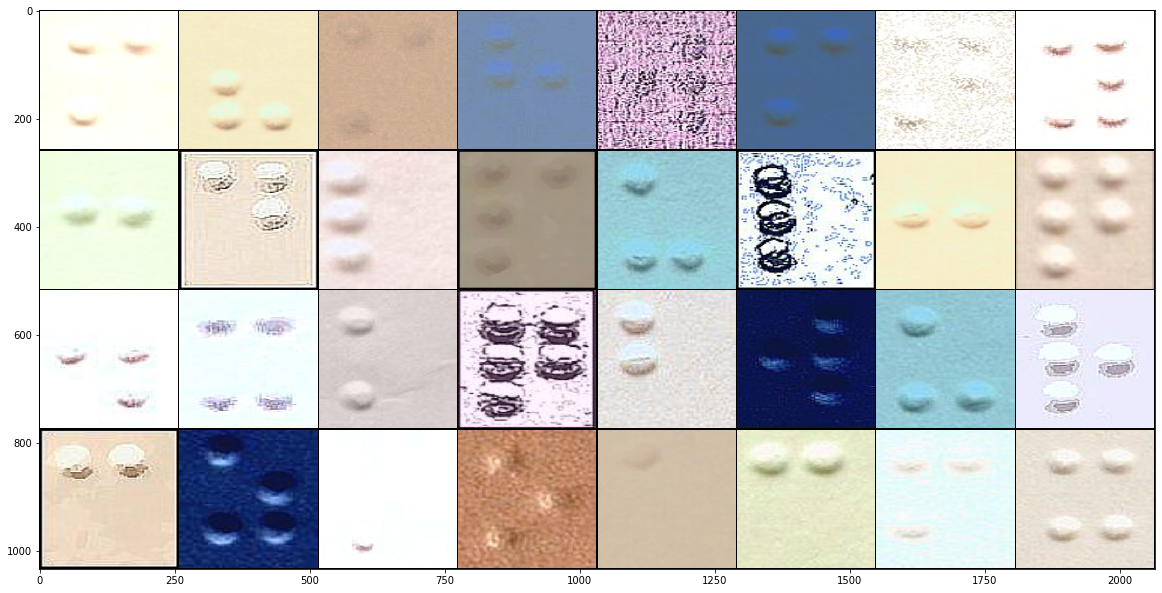

In [24]:
images , labels = batch

pred = network(images)

grid = torchvision.utils.make_grid(images,nrow=8)

plt.figure(figsize = (20,20))
plt.imshow(np.transpose(grid,(1,2,0)))

print('labels : ',labels)
print('prediction : ', pred.argmax(dim=1))
print('prediction tally : ',pred.argmax(dim=1).eq(labels))

print('Total correct predictions : ',pred.argmax(dim=1).eq(labels).sum().item())